<a href="https://colab.research.google.com/github/mchivuku/csb659-project/blob/master/Autoencoding_Beyond_Pixels_using_Learned_Similarity_Metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autoencoding beyond pixels using a learned similarity metric**-[paper]( https://arxiv.org/pdf/1512.09300.pdf)

In [1]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My\ Drive/Masters-DS/CSCI-B659/project/vae+gan

/content/drive/My Drive/Masters-DS/CSCI-B659/project/vae+gan


In [0]:
import os
#os.makedirs("vae+gan")
os.makedirs("results")

In [19]:
%ls

results/


## Import Libraries

In [0]:
from __future__ import print_function
import argparse
import h5py
import numpy as np
import os
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_and_save(file_name,img,show = False):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    fig = plt.figure(dpi=300)
    fig.suptitle(file_name, fontsize=14, fontweight='bold')
    #plt.imshow(npimg)
    if show:
      plt.axis("off")
      plt.imshow(npimg)
    else:
      plt.imsave(f,npimg)
    
def save_model(epoch, encoder, decoder, D):
    torch.save(decoder.cpu().state_dict(), './VAE_GAN_decoder_%d.pth' % epoch)
    torch.save(encoder.cpu().state_dict(),'./VAE_GAN_encoder_%d.pth' % epoch)
    torch.save(D.cpu().state_dict(), 'VAE_GAN_D_%d.pth' % epoch)
    decoder.cuda()
    encoder.cuda()
    D.cuda()
    
def load_model(epoch, encoder, decoder, D):
    #  restore models
    decoder.load_state_dict(torch.load('./VAE_GAN_decoder_%d.pth' % epoch))
    decoder.cuda()
    encoder.load_state_dict(torch.load('./VAE_GAN_encoder_%d.pth' % epoch))
    encoder.cuda()
    D.load_state_dict(torch.load('VAE_GAN_D_%d.pth' % epoch))
    D.cuda()

In [0]:
## Load DataSet
class Params:
  batch_size = 128
  data_dir="../examples/vae/MNIST/data"
  save_dir = "results/"
  nb_latents = 10

In [0]:
## Data loader
batch_size =  Params.batch_size

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(Params.data_dir, train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(Params.data_dir, train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

128


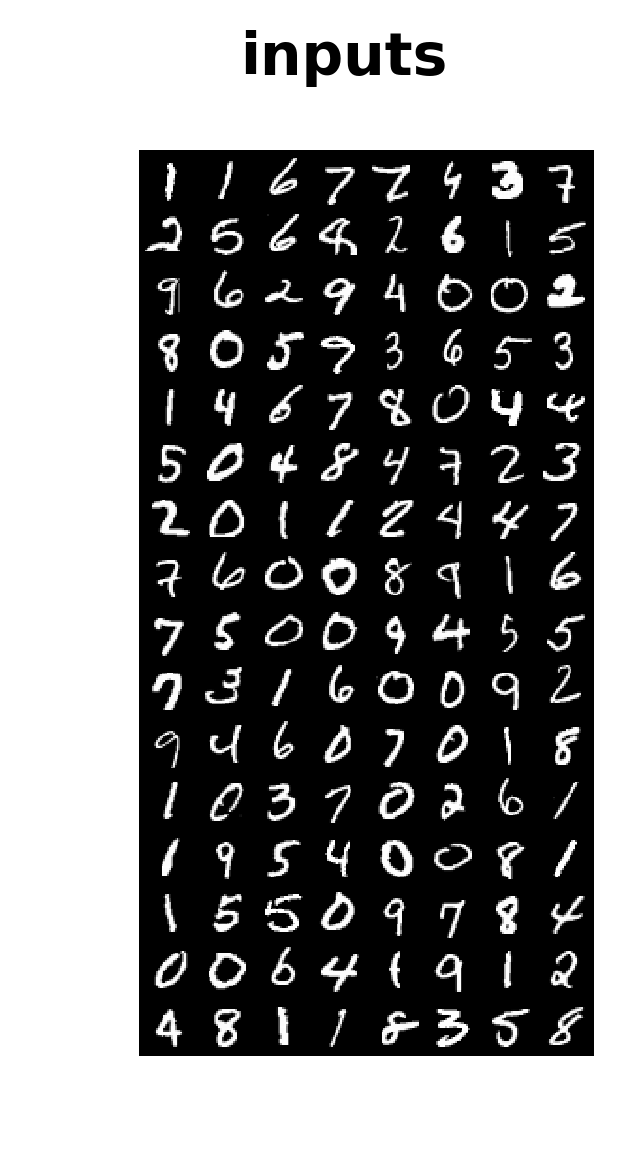

In [8]:
data, labels = next(iter(train_loader))
print(len(data))
show_and_save("inputs",make_grid(data.cpu(),8),True)


In [0]:
class Encoder(nn.Module):
    def __init__(self, input_channels, output_channels, representation_size = 32):
        super(Encoder, self).__init__()
        # input parameters
        self.input_channels = input_channels
        self.output_channels = output_channels #Params.nb_latents
        
        self.features = nn.Sequential(
            # nc x 32 x 32
            nn.Conv2d(self.input_channels, representation_size, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size),
            nn.ReLU(),
            # hidden_size x 16 x 16
            nn.Conv2d(representation_size, representation_size*2, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size * 2),
            nn.ReLU(),
            # hidden_size*2 x 8 x 8
            nn.Conv2d(representation_size*2, representation_size*4, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size * 4),
            nn.ReLU())
            # hidden_size*4 x 4 x 4
            
        self.mean = nn.Sequential(
            nn.Linear(representation_size*4*4*4, 1024),
             
            nn.ReLU(),
            nn.Linear(1024, output_channels))
        
        self.logvar = nn.Sequential(
            nn.Linear(representation_size*4*4*4, 1024),
          
            nn.ReLU(),
            nn.Linear(1024, output_channels))
        
    def forward(self, x):
        batch_size = x.size()[0]

        hidden_representation = self.features(x)
        hidden_representation = hidden_representation.view(-1, self.num_flat_features(hidden_representation))
        
        mean = self.mean(hidden_representation)
        logvar = self.logvar(hidden_representation)

        return mean, logvar
    
    def hidden_layer(self, x):
        batch_size = x.size()[0]
        output = self.features(x)
        return output
      
      
    def num_flat_features(self,x):
      size = x.size()[1:] # all dimensions except the batch dimension
      num_features = 1
      for s in size:
        num_features *=s
      return num_features

In [0]:
#encoder = Encoder(1,Params.nb_latents)
#mean, logvar = encoder(data[0].unsqueeze(0))

In [0]:
class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        
        self.input_size = input_size ##
        
        self.fc1 = nn.Linear(self.input_size, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024,7*7*64)
        
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        
        # 1 x 28 x 28
        self.activation = nn.Sigmoid()
        self.relu = nn.Tanh()
            
    
    def forward(self, z):
        bs = z.size()[0]
        
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
        x = self.deconv2(x)
       
        return self.activation(x)

In [0]:
encoder = Encoder(1,Params.nb_latents)
mean, logvar = encoder(data[0].unsqueeze(0))

hiddensize = encoder.hidden_layer(data[0].unsqueeze(0))

In [13]:
hiddensize.squeeze().shape,mean.shape

(torch.Size([128, 4, 4]), torch.Size([1, 10]))

In [14]:
decoder = Decoder(10,(128,4,4))
std = logvar.mul(0.5).exp_()
reparametrized_noise = Variable(torch.randn((batch_size, Params.nb_latents)))
reparametrized_noise = mean + std * reparametrized_noise
rec_images = decoder(reparametrized_noise)

TypeError: ignored

In [15]:
plt.imshow(rec_images[0].squeeze().detach().cpu(),cmap="gray")

NameError: ignored

In [0]:
class VAE_GAN_Generator(nn.Module):
    def __init__(self, input_channels, hidden_size):
        super(VAE_GAN_Generator, self).__init__()
        self.input_channels = input_channels
        self.hidden_size = hidden_size
        
        self.encoder = Encoder(input_channels, hidden_size)
        self.decoder = Decoder(hidden_size)
        
    def forward(self, x):
        batch_size = x.size()[0]
        mean, logvar = self.encoder(x)
        std = logvar.mul(0.5).exp_()
        
        reparametrized_noise = Variable(torch.randn((batch_size, self.hidden_size))).cuda()

        reparametrized_noise = mean + std * reparametrized_noise

        rec_images = self.decoder(reparametrized_noise)
        
        return mean, logvar, rec_images

In [0]:
class Discriminator(nn.Module):
    def __init__(self,input_channels, representation_size = 32):
        super(Discriminator, self).__init__()
        self.input_channels = input_channels
        dim = 128 * 4 * 4
        self.main = nn.Sequential(
            # nc x 32 x 32
            nn.Conv2d(self.input_channels, representation_size, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size),
            nn.LeakyReLU(0.2),
            # hidden_size x 16 x 16
            nn.Conv2d(representation_size, representation_size*2, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size * 2),
            nn.LeakyReLU(0.2),
            # hidden_size*2 x 8 x 8
            nn.Conv2d(representation_size*2, representation_size*4, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size * 4),
            nn.LeakyReLU(0.2))

        self.lth_features = nn.Sequential(
            nn.Linear(dim, 2048),
            nn.LeakyReLU(0.2))
            
        self.sigmoid_output = nn.Sequential(nn.Linear(2048,1),nn.Sigmoid())


    def forward(self, x):
        batch_size = x.size()[0]
        features = self.main(x)
        lth_rep = self.lth_features(features.view(batch_size, -1))
        output = self.sigmoid_output(lth_rep)
        return output
    
    def similarity(self, x):
        batch_size = x.size()[0]
        features = self.main(x)
        lth_rep = self.lth_features(features.view(batch_size, -1))
        return lth_rep

In [0]:
# define constant
input_channels = 1
hidden_size = 10
max_epochs = 250
lr = 3e-4

beta = 5
alpha = 0.1
gamma = 15

In [0]:
G = VAE_GAN_Generator(input_channels, hidden_size).cuda()
D = Discriminator(input_channels).cuda()

criterion = nn.BCELoss()
criterion.cuda()

opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)

In [0]:
fixed_noise = Variable(torch.randn(batch_size, hidden_size)).cuda()
data, _ = next(iter(train_loader))
fixed_batch = Variable(data).cuda()

In [0]:
## Loss
class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )
      

In [52]:

   
for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list =RunningAverage(), RunningAverage(), RunningAverage(),RunningAverage()
    g_loss_list, rec_loss_list, prior_loss_list = RunningAverage(),RunningAverage(),RunningAverage()
    for data, _ in train_loader:
        batch_size = data.size()[0]
        ones_label = Variable(torch.ones(batch_size)).cuda()
        zeros_label = Variable(torch.zeros(batch_size)).cuda()
        ## Run encoder - network + decoder
        datav = Variable(data).cuda()
        mean, logvar, rec_enc = G(datav)
        
        
        ## noise vector - same size as encoder 
        noisev = Variable(torch.randn(batch_size, hidden_size)).cuda()
        rec_noise = G.decoder(noisev) # decode noise
        
        # train discriminator
        output = D(datav)
        errD_real = criterion(output.squeeze(1), ones_label) ## real inputs
        D_real_list.update(output.data.mean())
        
        ## Fake inputs, 1. reconstructed output - x
        output = D(rec_enc)
        errD_rec_enc = criterion(output.squeeze(1), zeros_label)
        D_rec_enc_list.update(output.data.mean())
        
        
        ## Noise output
        output = D(rec_noise)
        errD_rec_noise = criterion(output.squeeze(1), zeros_label)
        D_rec_noise_list.update(output.data.mean())
        
        ## Total discriminator los
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
       
        D_list.update(dis_img_loss.data.mean())
        
        ## Discriminator
        opt_dis.zero_grad()
        dis_img_loss.backward(retain_graph=True)
        opt_dis.step()
        
        # train decoder
        output = D(datav)
        
        errD_real = criterion(output.squeeze(1), ones_label)
        
        output = D(rec_enc)
        errD_rec_enc = criterion(output.squeeze(1), zeros_label)
        
        output = D(rec_noise)
        errD_rec_noise = criterion(output.squeeze(1), zeros_label)
        
        similarity_rec_enc = D.similarity(rec_enc)
        similarity_data = D.similarity(datav)
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
        gen_img_loss = - dis_img_loss
        
        g_loss_list.update(gen_img_loss.data.mean())
        rec_loss = ((similarity_rec_enc - similarity_data) ** 2).mean()
        rec_loss_list.append(rec_loss.data.mean())
        err_dec = gamma * rec_loss + gen_img_loss ## Decoder Loss
        
        opt_dec.zero_grad()
        err_dec.backward(retain_graph=True)
        opt_dec.step()
        
        # train encoder
        prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
        prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
        
        prior_loss_list.update(prior_loss.data.mean())
        err_enc = prior_loss + beta * rec_loss ## Encoder Loss
        
        opt_enc.zero_grad()
        err_enc.backward()
        opt_enc.step()
        
    _, _, rec_imgs = G(fixed_batch)
    show_and_save('rec_epoch_%d.png' % epoch ,make_grid((rec_imgs.data*0.5+0.5).cpu(),8))
    
    samples = G.decoder(fixed_noise)
    vutils.save_image(samples.data,
            'sample_epoch_%d.png' % epoch,
            normalize=True)
    localtime = time.asctime( time.localtime(time.time()) )
    print (localtime)
    
    
    
    print ('[%d/%d]: D_real:%.4f, D_enc:%.4f, D_noise:%.4f, Loss_D:%.4f, Loss_G:%.4f, rec_loss:%.4f, prior_loss:%.4f' 
           % (epoch, 
              max_epochs, 
              (D_real_list()), 
              (D_rec_enc_list()), 
              (D_rec_noise_list()), 
              (D_list()), 
              (g_loss_list()),
              (rec_loss_list()),
              (prior_loss_list())))

Wed Apr 17 18:39:31 2019
[0/250]: D_real:0.3591, D_enc:0.3204, D_noise:0.3210, Loss_D:1.8314, Loss_G:-1.7730, rec_loss:0.0565, prior_loss:0.0176
Wed Apr 17 18:40:10 2019
[1/250]: D_real:0.3602, D_enc:0.3201, D_noise:0.3202, Loss_D:1.8278, Loss_G:-1.7684, rec_loss:0.0579, prior_loss:0.0189
Wed Apr 17 18:40:50 2019
[2/250]: D_real:0.3614, D_enc:0.3192, D_noise:0.3196, Loss_D:1.8239, Loss_G:-1.7628, rec_loss:0.0595, prior_loss:0.0209
Wed Apr 17 18:41:30 2019
[3/250]: D_real:0.3632, D_enc:0.3187, D_noise:0.3190, Loss_D:1.8195, Loss_G:-1.7582, rec_loss:0.0608, prior_loss:0.0225
Wed Apr 17 18:42:11 2019
[4/250]: D_real:0.3651, D_enc:0.3178, D_noise:0.3173, Loss_D:1.8119, Loss_G:-1.7507, rec_loss:0.0623, prior_loss:0.0236
Wed Apr 17 18:42:51 2019
[5/250]: D_real:0.3671, D_enc:0.3168, D_noise:0.3171, Loss_D:1.8082, Loss_G:-1.7448, rec_loss:0.0634, prior_loss:0.0256
Wed Apr 17 18:43:31 2019
[6/250]: D_real:0.3684, D_enc:0.3157, D_noise:0.3159, Loss_D:1.8031, Loss_G:-1.7396, rec_loss:0.0649, pri

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Wed Apr 17 18:52:51 2019
[20/250]: D_real:0.4229, D_enc:0.2880, D_noise:0.2889, Loss_D:1.6481, Loss_G:-1.5926, rec_loss:0.0819, prior_loss:0.0465
Wed Apr 17 18:53:31 2019
[21/250]: D_real:0.4313, D_enc:0.2844, D_noise:0.2837, Loss_D:1.6257, Loss_G:-1.5736, rec_loss:0.0831, prior_loss:0.0478
Wed Apr 17 18:54:11 2019
[22/250]: D_real:0.4359, D_enc:0.2826, D_noise:0.2814, Loss_D:1.6082, Loss_G:-1.5514, rec_loss:0.0840, prior_loss:0.0491
Wed Apr 17 18:54:51 2019
[23/250]: D_real:0.4442, D_enc:0.2786, D_noise:0.2765, Loss_D:1.5923, Loss_G:-1.5412, rec_loss:0.0851, prior_loss:0.0502
Wed Apr 17 18:55:31 2019
[24/250]: D_real:0.4504, D_enc:0.2755, D_noise:0.2746, Loss_D:1.5770, Loss_G:-1.5235, rec_loss:0.0863, prior_loss:0.0511
Wed Apr 17 18:56:11 2019
[25/250]: D_real:0.4561, D_enc:0.2731, D_noise:0.2706, Loss_D:1.5589, Loss_G:-1.5086, rec_loss:0.0873, prior_loss:0.0510
Wed Apr 17 18:56:51 2019
[26/250]: D_real:0.4622, D_enc:0.2695, D_noise:0.2673, Loss_D:1.5515, Loss_G:-1.4978, rec_loss:0.08

KeyboardInterrupt: ignored

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

In [0]:
save_model(epoch, G.encoder, G.decoder, D) # Save encoder, decoder and D


## Test Classifier

In [54]:
%ls

rec_epoch_0.png.png    rec_epoch_39.png.png  sample_epoch_166.png
rec_epoch_100.png.png  rec_epoch_3.png.png   sample_epoch_167.png
rec_epoch_101.png.png  rec_epoch_40.png.png  sample_epoch_168.png
rec_epoch_102.png.png  rec_epoch_41.png.png  sample_epoch_169.png
rec_epoch_103.png.png  rec_epoch_42.png.png  sample_epoch_16.png
rec_epoch_104.png.png  rec_epoch_43.png.png  sample_epoch_170.png
rec_epoch_105.png.png  rec_epoch_44.png.png  sample_epoch_171.png
rec_epoch_106.png.png  rec_epoch_45.png.png  sample_epoch_172.png
rec_epoch_107.png.png  rec_epoch_46.png.png  sample_epoch_173.png
rec_epoch_108.png.png  rec_epoch_47.png.png  sample_epoch_174.png
rec_epoch_109.png.png  rec_epoch_48.png.png  sample_epoch_175.png
rec_epoch_10.png.png   rec_epoch_49.png.png  sample_epoch_176.png
rec_epoch_110.png.png  rec_epoch_4.png.png   sample_epoch_177.png
rec_epoch_111.png.png  rec_epoch_50.png.png  sample_epoch_178.png
rec_epoch_112.png.png  rec_epoch_51.png.png  sample_epoch_179.png
rec_epoch_1

In [0]:
## Classifier
### Metrics - Base Class For all Metrics
class Metric:
  def __init__(self):
    pass
  def __call__(self, outputs, target, loss):
    raise NotImplementedError
    
  def reset(self):
    raise NotImplementedError
    
  def value(self):
    raise NotImplementedError
    
  def name(self):
    raise NotImplementedError
    
## Accuracy Metric
class AccumulatedAccuracyMetric(Metric):
  def __init__(self):
      self.correct = 0
      self.total = 0
      
  def __call__(self, outputs, target):
      # Track the accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (target == argmax.squeeze()).float().sum()
      self.correct += accuracy 
      self.total += target.size(0)
      return self.value()
  
  def reset(self):
      self.correct = 0
      self.total = 0

  def value(self):
      return 100 * float(self.correct) / self.total

  def name(self):
      return 'Accuracy'
    
    

In [0]:
save_dir = ""

"""
Traverse Latents
"""
def traverse_latents(model, datapoint, nb_latents, epoch, batch_idx, dirpath=save_dir):
  model.eval()
  datapoint = datapoint.to(device)
  if isinstance(model,ConvVAE):
    datapoint = datapoint.unsqueeze(0)
    mu, _ = model.encode(datapoint)
  else:
    mu, _ = model.encode(datapoint.view(-1))
  
  recons = torch.zeros((7, nb_latents, 28, 28))
  for zi in range(nb_latents):
    muc = mu.squeeze().clone()
    for i, val in enumerate(np.linspace(-3, 3, 7)):
      muc[zi] = val
      
      recon = model.decode(muc).cpu()
      recons[i, zi] = recon.view(28, 28)

  filename = os.path.join(dirpath, 'traversal_' + str(epoch) + '_' + str(batch_idx) + '.png')
  save_image(recons.view(-1, 1, 28, 28), filename, nrow=nb_latents, pad_value=1)
  
  
### Plot TSNE for latent space
# Show dataset images with T-sne projection of latent space encoding
import seaborn as sns
palette = np.array(sns.color_palette("hls", 10))
def visualize_tsne_of_input(X, labels, model, path):
    # Compute latent space representation
    print("Computing latent space projection...")
    
    X_encoded, _ = model.encode(X)
    
    # Compute t-SNE embedding of latent space
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded.data.detach().cpu())

    # Plot images according to t-sne embedding
    fig, ax = plt.subplots()
    im = plt.scatter(X_tsne[:,0], X_tsne[:,1],c=[palette[i] for i in labels])
    fig.colorbar(im, ticks=range(10));
    fig.savefig(path, dpi=fig.dpi)

In [59]:
#!pip install tqdm
!pip install opencv-python

In [0]:
## Import CV
import cv2
import numpy


def laplacian_variance(images):
    return [cv2.Laplacian(image.numpy(), cv2.CV_32F).var() for image in images]


def laplacian_variance_numpy(images):
    return [cv2.Laplacian(image, cv2.CV_32F).var() for image in images]


In [0]:
testpoint = torch.Tensor(train_loader.dataset[0][0]).cuda()


In [0]:
def traverse_latents(model, datapoint, nb_latents, epoch, batch_idx, dirpath=save_dir):
  model.eval()
  datapoint = datapoint.cuda()
  
  datapoint = datapoint.unsqueeze(0)
  mu, _ = model.encoder(datapoint)
  
  recons = torch.zeros((7, nb_latents, 28, 28))
  for zi in range(nb_latents):
    muc = mu.squeeze().clone()
    for i, val in enumerate(np.linspace(-3, 3, 7)):
      muc[zi] = val
      
      recon = model.decoder(muc).cpu()
      recons[i, zi] = recon.view(28, 28)

  filename = os.path.join(dirpath, 'traversal_' + str(epoch) + '_' + str(batch_idx) + '.png')
  save_image(recons.view(-1, 1, 28, 28), filename, nrow=nb_latents, pad_value=1)
  
traverse_latents(G, testpoint,Params.nb_latents, epoch,1,save_dir)

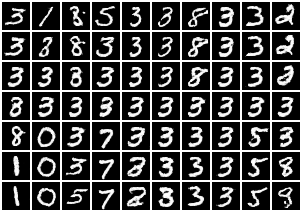

In [70]:
from IPython.display import Image
Image(filename=save_dir+f'traversal_210_1.png') 

In [0]:
train_dataset = datasets.MNIST(Params.data_dir,train=True,transform=transforms.ToTensor(),download=True)
testing_tsne = torch.utils.data.DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True)
test_data, test_labels = next(iter(testing_tsne))[:10000]


Computing latent space projection...


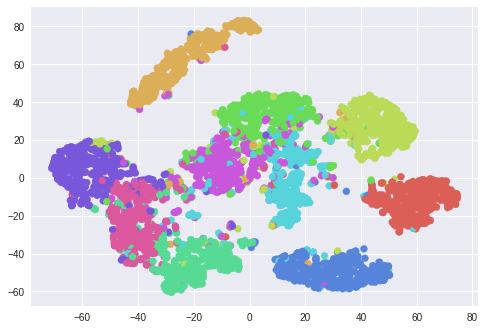

In [77]:

 
from scipy.stats import norm
from sklearn import manifold
path = save_dir+'latent_space.png'
def visualize_tsne(X, labels, model, path):
    # Compute latent space representation
    print("Computing latent space projection...")
    
    X_encoded, _ = model.encoder(X)
    
    # Compute t-SNE embedding of latent space
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded.data.detach().cpu())

    # Plot images according to t-sne embedding
    fig, ax = plt.subplots()
    im = plt.scatter(X_tsne[:,0], X_tsne[:,1],c=[palette[i] for i in labels])
    
    fig.savefig(path, dpi=fig.dpi)
    
visualize_tsne(test_data[:5000].cuda(),test_labels[:5000].cuda(),G,path)


In [0]:
x_test, y_test = test_data[:2000], test_labels[:2000]
not_ones = y_test != 1
x_test_not_ones, y_test_not_ones = x_test[not_ones], y_test[not_ones]
with torch.no_grad():
    reconstructions = np.empty(shape=(len(x_test_not_ones),1,28,28))
    
    indx = 0
    for i, (x,y) in enumerate(zip(x_test_not_ones,y_test_not_ones)):
      mean, logvar, rec_enc = G(x.unsqueeze(0).cuda())
      reconstructions[indx]=(rec_enc.squeeze(0).detach().cpu())
      indx+=1

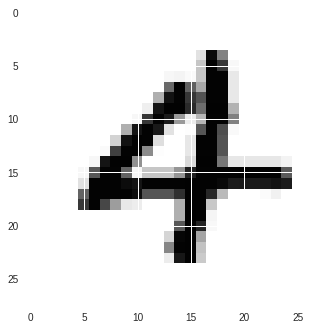

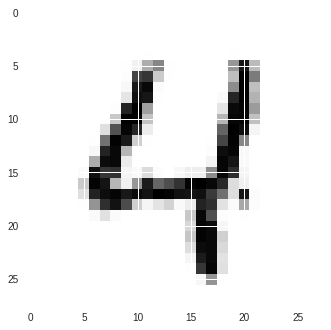

In [122]:
x_test_not_ones, y_test_not_ones = x_test[not_ones], y_test[not_ones]
len(y_test_not_ones)


plt.imshow(x_test_not_ones[5].squeeze(0))
plt.show()
plt.imshow(reconstructions[5].squeeze(0))
plt.show()

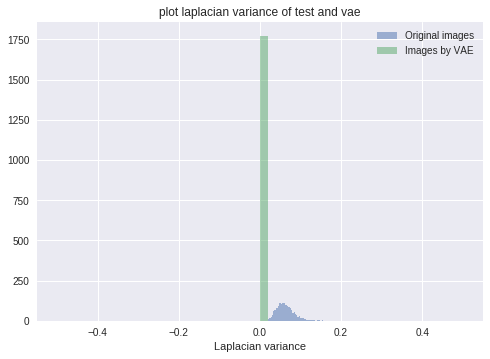

In [123]:
len(x_test[y_test==1])

not_ones = y_test != 1

lvs_1 = laplacian_variance(x_test[not_ones])
lvs_2 = laplacian_variance_numpy(np.array(reconstructions, dtype=np.uint8))
def plot_laplacian_variances(lvs_1, lvs_2, title):
    plt.hist(lvs_1, bins=50, alpha=0.5 , label='Original images');
    plt.hist(lvs_2, bins=50, alpha= 0.5 , label='Images by VAE');
    plt.xlabel('Laplacian variance')
    plt.title(title)
    plt.legend();
    
plot_laplacian_variances(lvs_1, lvs_2, "plot laplacian variance of test and vae")

In [0]:
import torch.nn.functional as F
import torch.optim as optim
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier,self).__init__()
    
    ## Define NN
    self.fc1 = nn.Linear(10, 10)
    
    
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features

In [0]:
## Training
from tqdm import trange

criterion = nn.CrossEntropyLoss()
classifier = Classifier()
classifier = classifier.cuda()

# Loss and optimizer
learning_rate = 0.001
momemtum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
       

In [0]:
## Train Classifier with pretrained vae
vae_parameters = list(G.encoder.named_parameters())
for name, param in vae_parameters:
    param.requires_grad = False
    
## Train Classifier with pretrained vae
vae_parameters = list(G.decoder.named_parameters())
for name, param in vae_parameters:
    param.requires_grad = False

In [0]:
def train_classifier_epoch(epoch):
  classifier.train()
  metric = AccumulatedAccuracyMetric()
  losses = RunningAverage()
  for idx, (data, labels) in enumerate(train_loader):
    data= data.cuda()
    labels = labels.cuda()
    
    
    mu, logvar,recon_batch = G(data)
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    classifier_loss.backward()
    optimizer.step()
    
    classifier_loss /= data.size(0)
    losses.update(classifier_loss)
    
    metric(outputs, labels)
    
    
  return losses(), metric

## Test Epoch
"""
Test, classifier on learnt features
"""
def test_classifier_epoch(epoch):
  classifier.eval()
  metric = AccumulatedAccuracyMetric()
  losses = RunningAverage()
  for idx, (data, labels) in enumerate(test_loader):
    data= data.cuda()
    labels = labels.cuda()
    
    
    mu, logvar,recon_batch = G(data)
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss = criterion(outputs, labels)
    
    classifier_loss /= data.size(0)
    losses.update(classifier_loss)
    
    metric(outputs, labels)
    
    
  return losses(), metric

In [141]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
n_epochs = 50
for epoch in range(1, n_epochs):
  
  # Train stage
  train_loss, metric = train_classifier_epoch(epoch)
  train_losses.append(train_loss)
  train_accuracy.append(metric.value())
  
  message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
  message += '\t Average Accuracy: \t{}: {}'.format(metric.name(), metric.value())
  print(message)
  
  val_loss, metrics = test_classifier_epoch(epoch)
  test_losses.append(val_loss)
  test_accuracy.append(metrics.value())
  
  message += '\nEpoch: {}/{}. Test set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
  
  message += '\t Average Accuracy: \t{}: {}'.format(metrics.name(), metrics.value())

  
  print(message)

Epoch: 2/50. Train set: Average loss: 0.0148	 Average Accuracy: 	Accuracy: 48.78333333333333
Epoch: 2/50. Train set: Average loss: 0.0148	 Average Accuracy: 	Accuracy: 48.78333333333333
Epoch: 2/50. Test set: Average loss: 0.0128	 Average Accuracy: 	Accuracy: 71.89
Epoch: 3/50. Train set: Average loss: 0.0100	 Average Accuracy: 	Accuracy: 76.785
Epoch: 3/50. Train set: Average loss: 0.0100	 Average Accuracy: 	Accuracy: 76.785
Epoch: 3/50. Test set: Average loss: 0.0090	 Average Accuracy: 	Accuracy: 81.3
Epoch: 4/50. Train set: Average loss: 0.0076	 Average Accuracy: 	Accuracy: 82.585
Epoch: 4/50. Train set: Average loss: 0.0076	 Average Accuracy: 	Accuracy: 82.585
Epoch: 4/50. Test set: Average loss: 0.0074	 Average Accuracy: 	Accuracy: 84.75
Epoch: 5/50. Train set: Average loss: 0.0062	 Average Accuracy: 	Accuracy: 84.51666666666667
Epoch: 5/50. Train set: Average loss: 0.0062	 Average Accuracy: 	Accuracy: 84.51666666666667
Epoch: 5/50. Test set: Average loss: 0.0061	 Average Accuracy

Text(0.5, 1.0, 'train and test loss')

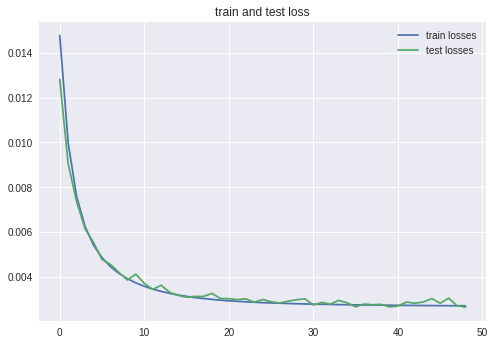

In [143]:
plt.plot(range(n_epochs-1),train_losses)
plt.plot(range(n_epochs-1),test_losses)
plt.legend(["train losses","test losses"])
plt.title("train and test loss")

Text(0.5, 1.0, 'train and test accuracy')

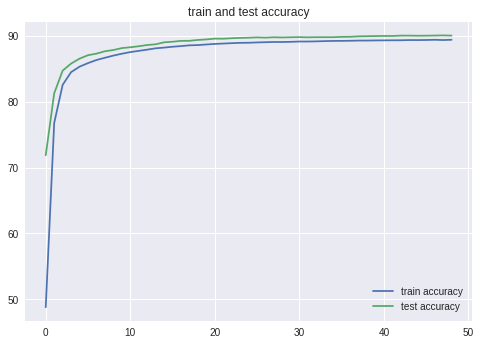

In [144]:
plt.plot(range(n_epochs-1),train_accuracy)
plt.plot(range(n_epochs-1),test_accuracy)
plt.legend(["train accuracy","test accuracy"])
plt.title("train and test accuracy")

